In [1]:
import pandas as pd
import os
import sys
import numpy as np
import shutil
import glob
import geopandas as gpd
import matplotlib.pyplot as plt

# suppress pandas purely educational warnings
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws, min_max_standardize
from scripts.utils.write_metadata import append_metadata
from scripts.utils.index_plot import index_plot

In [2]:
# pull csv from aws
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data/'

pull_csv_from_directory(bucket_name, aws_dir, search_zipped=False)

Saved DataFrame as 'built_housing_median_age_metric.csv'
Saved DataFrame as 'built_housing_mobile_homes_metric.csv'
Saved DataFrame as 'built_housing_quality_metric.csv'
Saved DataFrame as 'built_metric_housing_vacancy_metric.csv'
Saved DataFrame as 'built_power_plant_metric.csv'
Saved DataFrame as 'climate_wildfire_redbooks_loss_metric.csv'
Saved DataFrame as 'climate_wildfire_redbooks_loss_metric_buildings.csv'
Saved DataFrame as 'climate_wildfire_redbooks_loss_metric_fatalities.csv'
Saved DataFrame as 'governance_emergency_management_metric.csv'
Saved DataFrame as 'governance_hazard_mitigation_metric.csv'
Saved DataFrame as 'natural_air_quality_metric.csv'
Saved DataFrame as 'society_ambulatory_disability_metric.csv'
Saved DataFrame as 'society_american_indian_alaska_native_metric.csv'
Saved DataFrame as 'society_cognitive_disability_metric.csv'
Saved DataFrame as 'society_financial_assistance_metric.csv'
Saved DataFrame as 'society_food_access_metric.csv'
Saved DataFrame as 'societ

In [3]:
# Define the output folder path
output_folder = 'output_folder'

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Find all CSV files starting with 'society_'
source_files = [file for file in glob.glob('society_*.csv') if 'social' not in file]

# Iterate through the source files and copy only CSV files to the output folder
for file in source_files:
    # Construct the destination file path
    destination_path = os.path.join(output_folder, os.path.basename(file))
    
    # Copy the file to the output folder
    shutil.copyfile(file, destination_path)
    
    # Remove the original file
    os.remove(file)

print(f"Copied and removed {len(source_files)} CSV files.")

# Delete all CSV files in the current directory that are not in the output folder
current_files = glob.glob('*.csv')
for file in current_files:
    if file not in [os.path.basename(f) for f in source_files]:
        os.remove(file)

print(f"Deleted {len(current_files) - len(source_files)} local CSV files.")


Copied and removed 21 CSV files.
Deleted 1 local CSV files.


In [4]:
# Define the output folder path
output_folder = 'output_folder'

# Get a list of all CSV files in the output folder
csv_files = glob.glob(os.path.join(output_folder, '*.csv'))

# Initialize an empty DataFrame for merging
merged_df = pd.DataFrame()
# Iterate through each CSV file and merge them on the 'census_tract' column
for file in csv_files:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file)
    
    # Keep only the 'census_tract' and the last column from each file
    last_column = df.columns[-1]
    df = df[['census_tract', last_column]]
    
    # Merge the DataFrame with the existing merged DataFrame
    if merged_df.empty:
        merged_df = df
    else:
        merged_df = pd.merge(merged_df, df, on='census_tract', how='outer')

# Save the merged DataFrame to a CSV file
merged_df.to_csv('concatenate_society_economy_metrics.csv', index=False)

print(f"Merged CSV saved as concatenate_society_economy_metrics.csv")

Merged CSV saved as concatenate_society_economy_metrics.csv


In [5]:
society_economy_metrics = pd.read_csv('concatenate_society_economy_metrics.csv')
society_economy_metrics

,census_tract,percent_population_ambulatory_disabilities,percent_total_pop_american_indian_alaska_native,percent_population_cognitive_disabilities,percent_children_household_financial_assistance,percent_1miurban_10mirural,real_percent_total_pop_over_65,percent_total_pop_under_5,asthma_related_ed_visits_per_10000_people_2021,cardiovascular_disease_related_ed_visits_per_10000_people_2021,...,housing_burden_percent_2019,sum_imp_water_bodies,linguistic_isolation_percent_2019,low_birth_weight_percent_2019,Percent of households without air conditioning,Percent of population employed and aged > 16 working outdoors,poverty_percent_2019,unemployment_percent_2019,"Number of Violent Crimes per 1,000 Population",percent_population_without_health_insurance
0,6.001400e+09,4.680330,0.0,5.170005,15.885023,58.256725,27.041909,4.1,47.873968,16.029367,...,11.200000,2.0,1.200000,3.850000,64.306645,0.919842,10.400000,4.823653,7.267424,0.275314
1,6.001400e+09,4.005589,0.4,1.904253,0.000000,30.832177,25.756870,7.9,95.342338,37.913367,...,4.000000,0.0,0.000000,4.050000,64.306645,1.595745,10.600000,3.000000,7.267424,0.838379
2,6.001400e+09,2.295782,0.5,3.529687,3.184713,30.832177,16.301833,2.3,54.956398,15.803524,...,8.900000,0.0,8.000000,3.780000,64.306645,1.152702,10.300000,3.900000,7.267424,1.655099
3,6.001400e+09,3.646564,0.5,3.165358,14.240170,30.832177,12.856475,7.5,115.965404,18.887331,...,14.800000,0.0,0.900000,4.440000,64.306645,2.146272,21.100000,2.500000,7.267424,2.244039
4,6.001400e+09,3.367941,0.1,6.219631,4.435484,30.832177,16.434540,4.0,219.220056,28.184350,...,14.800000,0.0,1.700000,3.640000,64.306645,3.771252,21.900000,3.800000,7.267424,4.482147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9125,6.115041e+09,8.387800,0.3,3.745976,0.000000,37.636696,33.605664,6.9,136.719317,54.487412,...,19.722222,3.0,5.916667,4.863333,1.725293,11.883790,48.111111,9.388889,4.906318,2.777778
9126,6.115041e+09,9.160082,2.6,9.702797,0.000000,37.636696,29.997073,2.6,146.922251,58.553637,...,19.722222,3.0,5.916667,4.863333,1.725293,11.883790,48.111111,9.388889,4.906318,15.510682
9127,6.115041e+09,16.826923,1.1,9.405941,44.331984,37.636696,20.891608,2.7,219.420163,87.446581,...,19.722222,3.0,5.916667,4.863333,1.725293,11.883790,48.111111,9.388889,4.906318,7.430070
9128,6.115041e+09,12.277228,0.0,NaN,42.857143,37.636696,53.960396,4.9,497.062706,198.096810,...,19.722222,3.0,5.916667,4.863333,1.725293,11.883790,48.111111,9.388889,4.906318,0.000000


In [6]:
def handle_outliers(df, output_csv):
    # Columns to process (exclude 'census_tract')
    columns_to_process = [col for col in df.columns if col != 'census_tract']
    
    # Dictionary to store counts of adjusted rows
    adjusted_counts = {}

    for column in columns_to_process:
        # Convert the column to numeric, forcing any errors to NaN
        df[column] = pd.to_numeric(df[column], errors='coerce')
        
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        if IQR == 0:
            print(f"Column '{column}' has no IQR (Q1 == Q3). Skipping outlier handling for this column.")
            continue

        max_fence = Q3 * 3
        min_fence = Q1 * -3

        print(f'For column {column}:')
        print(f'  Q1 (25th percentile): {Q1}')
        print(f'  Q3 (75th percentile): {Q3}')
        print(f'  IQR: {IQR}')
        print(f'  Max fence: {max_fence}')
        print(f'  Min fence: {min_fence}')

        # Identify outliers
        outliers = df[(df[column] > max_fence) | (df[column] < min_fence)]
        
        # Print outliers and their corresponding 'census_tract'
        if not outliers.empty:
            print(f"Outliers detected in column '{column}':")
            for _, row in outliers.iterrows():
                print(f"census_tract: {row['census_tract']}, value: {row[column]}")

        # Count the number of adjustments
        count_adjusted = df[(df[column] > max_fence) | (df[column] < min_fence)].shape[0]
        adjusted_counts[column] = count_adjusted
        
        # Clip the outliers
        df[column] = df[column].clip(lower=min_fence, upper=max_fence)
    
    # Save the updated DataFrame back to CSV
    df.to_csv(output_csv, index=False)
    
    # Print the adjusted counts
    print("Number of rows adjusted per column:")
    for column, count in adjusted_counts.items():
        print(f"  {column}: {count}")

    return df

# Handle outliers
handle_outlier_csv = 'no_outlier_society_economy_metrics.csv'
output = handle_outliers(society_economy_metrics, handle_outlier_csv)
print(f"Processed and saved {handle_outlier_csv} with outlier handling.")

For column percent_population_ambulatory_disabilities:
  Q1 (25th percentile): 3.4249678882757117
  Q3 (75th percentile): 7.035102433873741
  IQR: 3.610134545598029
  Max fence: 21.105307301621224
  Min fence: -10.274903664827136
Outliers detected in column 'percent_population_ambulatory_disabilities':
census_tract: 6013351105.0, value: 21.223814773980155
census_tract: 6025012400.0, value: 21.39219015280136
census_tract: 6033000601.0, value: 22.210690192008304
census_tract: 6037125322.0, value: 21.15093387178193
census_tract: 6037206301.0, value: 31.129864041256443
census_tract: 6037206302.0, value: 25.71554381329811
census_tract: 6037206303.0, value: 28.146536089952846
census_tract: 6037302201.0, value: 22.377807133421403
census_tract: 6037310701.0, value: 22.231614539306847
census_tract: 6037980014.0, value: 48.888888888888886
census_tract: 6037980021.0, value: 23.52941176470588
census_tract: 6039000111.0, value: 21.643109540636043
census_tract: 6059021813.0, value: 84.61538461538461

In [7]:
no_outlier_society_economy_metrics = pd.read_csv('no_outlier_society_economy_metrics.csv')
no_outlier_society_economy_metrics

,census_tract,percent_population_ambulatory_disabilities,percent_total_pop_american_indian_alaska_native,percent_population_cognitive_disabilities,percent_children_household_financial_assistance,percent_1miurban_10mirural,real_percent_total_pop_over_65,percent_total_pop_under_5,asthma_related_ed_visits_per_10000_people_2021,cardiovascular_disease_related_ed_visits_per_10000_people_2021,...,housing_burden_percent_2019,sum_imp_water_bodies,linguistic_isolation_percent_2019,low_birth_weight_percent_2019,Percent of households without air conditioning,Percent of population employed and aged > 16 working outdoors,poverty_percent_2019,unemployment_percent_2019,"Number of Violent Crimes per 1,000 Population",percent_population_without_health_insurance
0,6.001400e+09,4.680330,0.0,5.170005,15.885023,58.256725,27.041909,4.1,47.873968,16.029367,...,11.200000,2.0,1.200000,3.850000,64.306645,0.919842,10.400000,4.823653,7.267424,0.275314
1,6.001400e+09,4.005589,0.4,1.904253,0.000000,30.832177,25.756870,7.9,95.342338,37.913367,...,4.000000,0.0,0.000000,4.050000,64.306645,1.595745,10.600000,3.000000,7.267424,0.838379
2,6.001400e+09,2.295782,0.5,3.529687,3.184713,30.832177,16.301833,2.3,54.956398,15.803524,...,8.900000,0.0,8.000000,3.780000,64.306645,1.152702,10.300000,3.900000,7.267424,1.655099
3,6.001400e+09,3.646564,0.5,3.165358,14.240170,30.832177,12.856475,7.5,115.965404,18.887331,...,14.800000,0.0,0.900000,4.440000,64.306645,2.146272,21.100000,2.500000,7.267424,2.244039
4,6.001400e+09,3.367941,0.1,6.219631,4.435484,30.832177,16.434540,4.0,219.220056,28.184350,...,14.800000,0.0,1.700000,3.640000,64.306645,3.771252,21.900000,3.800000,7.267424,4.482147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9125,6.115041e+09,8.387800,0.3,3.745976,0.000000,37.636696,33.605664,6.9,136.719317,54.487412,...,19.722222,3.0,5.916667,4.863333,1.725293,11.883790,48.111111,9.388889,4.906318,2.777778
9126,6.115041e+09,9.160082,2.6,9.702797,0.000000,37.636696,29.997073,2.6,146.922251,58.553637,...,19.722222,3.0,5.916667,4.863333,1.725293,11.883790,48.111111,9.388889,4.906318,15.510682
9127,6.115041e+09,16.826923,1.1,9.405941,44.331984,37.636696,20.891608,2.7,219.420163,87.446581,...,19.722222,3.0,5.916667,4.863333,1.725293,11.883790,48.111111,9.388889,4.906318,7.430070
9128,6.115041e+09,12.277228,0.0,NaN,42.857143,37.636696,53.960396,4.9,497.062706,135.154242,...,19.722222,3.0,5.916667,4.863333,1.725293,11.883790,48.111111,9.388889,4.906318,0.000000


Metrics are now min-max standardized on 0.01 to 0.99 scale

In [8]:
def min_max_standardize(df, cols_to_run_on):
    '''
    Calculates min and max values for specified columns, then calculates
    min-max standardized values. Min, max, and standardized value columns are created and
    added to the dataframe with a prefix based on the column names.

    Parameters
    ----------
    df: DataFrame
        Input dataframe   
    cols_to_run_on: list
        List of columns to calculate min, max, and standardize
    '''
    for col in cols_to_run_on:
        max_value = df[col].max()
        min_value = df[col].min()

        # Get min-max values, standardize, and add columns to df
        prefix = col # Extracting the prefix from the column name
        df[f'{prefix}_min'] = min_value
        df[f'{prefix}_max'] = max_value
        df[f'{prefix}_min_max_standardized'] = ((df[col] - min_value) / (max_value - min_value))
        
        # note to add checker to make sure new min_max column values arent < 0 >
        
        
        # Drop the original columns
        df.drop(columns=[col], inplace=True)
     
    return df


In [9]:
columns_to_process = [col for col in no_outlier_society_economy_metrics.columns if col != 'census_tract']

min_max_metrics = min_max_standardize(no_outlier_society_economy_metrics, columns_to_process)
min_max_metrics.head()

,census_tract,percent_population_ambulatory_disabilities_min,percent_population_ambulatory_disabilities_max,percent_population_ambulatory_disabilities_min_max_standardized,percent_total_pop_american_indian_alaska_native_min,percent_total_pop_american_indian_alaska_native_max,percent_total_pop_american_indian_alaska_native_min_max_standardized,percent_population_cognitive_disabilities_min,percent_population_cognitive_disabilities_max,percent_population_cognitive_disabilities_min_max_standardized,...,poverty_percent_2019_min_max_standardized,unemployment_percent_2019_min,unemployment_percent_2019_max,unemployment_percent_2019_min_max_standardized,"Number of Violent Crimes per 1,000 Population_min","Number of Violent Crimes per 1,000 Population_max","Number of Violent Crimes per 1,000 Population_min_max_standardized",percent_population_without_health_insurance_min,percent_population_without_health_insurance_max,percent_population_without_health_insurance_min_max_standardized
0,6.001400e+09,0.0,21.105307,0.221761,0.0,3.9,0.000000,0.0,17.135952,0.301705,...,0.103753,0.0,23.532482,0.204978,2.135525,8.573265,0.797158,0.0,29.677171,0.009277
1,6.001400e+09,0.0,21.105307,0.189791,0.0,3.9,0.102564,0.0,17.135952,0.111126,...,0.105960,0.0,23.532482,0.127483,2.135525,8.573265,0.797158,0.0,29.677171,0.028250
2,6.001400e+09,0.0,21.105307,0.108777,0.0,3.9,0.128205,0.0,17.135952,0.205981,...,0.102649,0.0,23.532482,0.165728,2.135525,8.573265,0.797158,0.0,29.677171,0.055770
3,6.001400e+09,0.0,21.105307,0.172779,0.0,3.9,0.128205,0.0,17.135952,0.184720,...,0.221854,0.0,23.532482,0.106236,2.135525,8.573265,0.797158,0.0,29.677171,0.075615
4,6.001400e+09,0.0,21.105307,0.159578,0.0,3.9,0.025641,0.0,17.135952,0.362958,...,0.230684,0.0,23.532482,0.161479,2.135525,8.573265,0.797158,0.0,29.677171,0.151030


In [10]:
words = ['census_tract','standardized']
selected_columns = []
for word in words:
    selected_columns.extend(min_max_metrics.columns[min_max_metrics.columns.str.contains(word)].tolist())

min_max_standardized_society_economy_metrics_df = min_max_metrics[selected_columns]
pd.set_option('display.max_columns', None)

min_max_standardized_society_economy_metrics_df


,census_tract,percent_population_ambulatory_disabilities_min_max_standardized,percent_total_pop_american_indian_alaska_native_min_max_standardized,percent_population_cognitive_disabilities_min_max_standardized,percent_children_household_financial_assistance_min_max_standardized,percent_1miurban_10mirural_min_max_standardized,real_percent_total_pop_over_65_min_max_standardized,percent_total_pop_under_5_min_max_standardized,asthma_related_ed_visits_per_10000_people_2021_min_max_standardized,cardiovascular_disease_related_ed_visits_per_10000_people_2021_min_max_standardized,education_percent_2019_min_max_standardized,avg_percent_population_homeless_min_max_standardized,housing_burden_percent_2019_min_max_standardized,sum_imp_water_bodies_min_max_standardized,linguistic_isolation_percent_2019_min_max_standardized,low_birth_weight_percent_2019_min_max_standardized,Percent of households without air conditioning_min_max_standardized,Percent of population employed and aged > 16 working outdoors_min_max_standardized,poverty_percent_2019_min_max_standardized,unemployment_percent_2019_min_max_standardized,"Number of Violent Crimes per 1,000 Population_min_max_standardized",percent_population_without_health_insurance_min_max_standardized
0,6.001400e+09,0.221761,0.000000,0.301705,0.158850,0.628778,0.462529,0.192488,0.084114,0.108084,0.045267,0.173761,0.154990,0.111111,0.028571,0.280817,0.643066,0.034865,0.103753,0.204978,0.797158,0.009277
1,6.001400e+09,0.189791,0.102564,0.111126,0.000000,0.332779,0.440549,0.370892,0.171710,0.271935,0.005487,0.173761,0.047689,0.000000,0.000000,0.295405,0.643066,0.060484,0.105960,0.127483,0.797158,0.028250
2,6.001400e+09,0.108777,0.128205,0.205981,0.031847,0.332779,0.278829,0.107981,0.097184,0.106393,0.076818,0.173761,0.120714,0.000000,0.190476,0.275711,0.643066,0.043692,0.102649,0.165728,0.797158,0.055770
3,6.001400e+09,0.172779,0.128205,0.184720,0.142402,0.332779,0.219899,0.352113,0.209767,0.129483,0.065844,0.173761,0.208641,0.000000,0.021429,0.323851,0.643066,0.081351,0.221854,0.106236,0.797158,0.075615
4,6.001400e+09,0.159578,0.025641,0.362958,0.044355,0.332779,0.281099,0.187793,0.400310,0.199092,0.031550,0.173761,0.208641,0.000000,0.040476,0.265500,0.643066,0.142944,0.230684,0.161479,0.797158,0.151030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9125,6.115041e+09,0.397426,0.076923,0.218603,0.000000,0.406222,0.574796,0.323944,0.248066,0.396029,0.315348,0.343100,0.281996,0.166667,0.140873,0.354729,0.017253,0.450439,0.519990,0.398976,0.430398,0.093600
9126,6.115041e+09,0.434018,0.666667,0.566225,0.000000,0.406222,0.513074,0.122066,0.266894,0.426473,0.315348,0.343100,0.281996,0.166667,0.140873,0.354729,0.017253,0.450439,0.519990,0.398976,0.430398,0.522647
9127,6.115041e+09,0.797284,0.282051,0.548901,0.443320,0.406222,0.357333,0.126761,0.400679,0.642802,0.315348,0.343100,0.281996,0.166667,0.140873,0.354729,0.017253,0.450439,0.519990,0.398976,0.430398,0.250363
9128,6.115041e+09,0.581713,0.000000,NaN,0.428571,0.406222,0.922946,0.230047,0.913030,1.000000,0.315348,0.343100,0.281996,0.166667,0.140873,0.354729,0.017253,0.450439,0.519990,0.398976,0.430398,0.000000


In [11]:

testing = pd.DataFrame()
testing['census_tract'] = min_max_standardized_society_economy_metrics_df['census_tract']
testing['average'] = min_max_standardized_society_economy_metrics_df.drop(columns=['census_tract']).mean(axis=1)

testing

,census_tract,average
0,6.001400e+09,0.225996
1,6.001400e+09,0.203623
2,6.001400e+09,0.192549
3,6.001400e+09,0.218617
4,6.001400e+09,0.230471
...,...,...
9125,6.115041e+09,0.293113
9126,6.115041e+09,0.349717
9127,6.115041e+09,0.365499
9128,6.115041e+09,0.395115


In [12]:
min_max_standardized_society_economy_metrics_df.columns

Index(['census_tract',
       'percent_population_ambulatory_disabilities_min_max_standardized',
       'percent_total_pop_american_indian_alaska_native_min_max_standardized',
       'percent_population_cognitive_disabilities_min_max_standardized',
       'percent_children_household_financial_assistance_min_max_standardized',
       'percent_1miurban_10mirural_min_max_standardized',
       'real_percent_total_pop_over_65_min_max_standardized',
       'percent_total_pop_under_5_min_max_standardized',
       'asthma_related_ed_visits_per_10000_people_2021_min_max_standardized',
       'cardiovascular_disease_related_ed_visits_per_10000_people_2021_min_max_standardized',
       'education_percent_2019_min_max_standardized',
       'avg_percent_population_homeless_min_max_standardized',
       'housing_burden_percent_2019_min_max_standardized',
       'sum_imp_water_bodies_min_max_standardized',
       'linguistic_isolation_percent_2019_min_max_standardized',
       'low_birth_weight_perce

In [13]:
metric_to_indicator_dict = {
    'vulnerable_populations' : ['asthma', 
                                'cardiovascular_disease', 
                                'birth_weight',
                                'education',
                                'linguistic',
                                'poverty', 
                                'unemployment',
                                'housing_burden',
                                'imp_water_bodies',
                                'homeless',
                                'health_insurance',
                                'ambulatory_disabilities',
                                'cognitive_disabilities',
                                'air conditioning',
                                'Violent Crimes',
                                'working outdoors', 
                                '1miurban_10mirural',
                                'american_indian',
                                'over_65',
                                'under_5',
                                'household_financial_assistance']
}

In [14]:
# Create an empty DataFrame to store the results
averaged_indicators_society_economy = pd.DataFrame()

# Iterate through the items of the dictionary
for indicator, keywords in metric_to_indicator_dict.items():
    # Filter columns based on the keyword values for the current indicator
    indicator_columns = [col for col in min_max_standardized_society_economy_metrics_df.columns if any(keyword in col for keyword in keywords)]
    
    # Compute the average of the selected columns
    averaged_values = min_max_standardized_society_economy_metrics_df[indicator_columns].mean(axis=1)
    print(indicator_columns)
    print(len(indicator_columns))
    # Store the averaged values in the result DataFrame with the indicator name as the column name
    averaged_indicators_society_economy[indicator] = averaged_values
    
# Include the 'census_tract' column from the original DataFrame
averaged_indicators_society_economy['census_tract'] = min_max_standardized_society_economy_metrics_df['census_tract']
# Reorder the columns to have 'census_tract' as the first column

averaged_indicators_society_economy = averaged_indicators_society_economy[['census_tract'] + [col for col in averaged_indicators_society_economy.columns if col != 'census_tract']]
# Show the resulting DataFrame
print(averaged_indicators_society_economy)


['percent_population_ambulatory_disabilities_min_max_standardized', 'percent_total_pop_american_indian_alaska_native_min_max_standardized', 'percent_population_cognitive_disabilities_min_max_standardized', 'percent_children_household_financial_assistance_min_max_standardized', 'percent_1miurban_10mirural_min_max_standardized', 'real_percent_total_pop_over_65_min_max_standardized', 'percent_total_pop_under_5_min_max_standardized', 'asthma_related_ed_visits_per_10000_people_2021_min_max_standardized', 'cardiovascular_disease_related_ed_visits_per_10000_people_2021_min_max_standardized', 'education_percent_2019_min_max_standardized', 'avg_percent_population_homeless_min_max_standardized', 'housing_burden_percent_2019_min_max_standardized', 'sum_imp_water_bodies_min_max_standardized', 'linguistic_isolation_percent_2019_min_max_standardized', 'low_birth_weight_percent_2019_min_max_standardized', 'Percent of households without air conditioning_min_max_standardized', 'Percent of population em

In [15]:
# Create a new DataFrame to store the results
summed_indicators_society_economy = pd.DataFrame()

# Calculate the sum of all columns except 'census_tract'
columns_to_process = [col for col in averaged_indicators_society_economy.columns if col != 'census_tract']

summed_values = averaged_indicators_society_economy[columns_to_process].sum(axis=1)

# Store the summed values in the result DataFrame with the column name 'summed_indicators_society_economy_domain'
summed_indicators_society_economy['summed_indicators_society_economy_domain'] = summed_values

# Include the 'census_tract' column from the original DataFrame
summed_indicators_society_economy['census_tract'] = averaged_indicators_society_economy['census_tract']

# Reorder the columns to have 'census_tract' as the first column
summed_indicators_society_economy = summed_indicators_society_economy[['census_tract', 'summed_indicators_society_economy_domain']]

# Show the resulting DataFrame
print(summed_indicators_society_economy)

      census_tract  summed_indicators_society_economy_domain
0     6.001400e+09                                  0.225996
1     6.001400e+09                                  0.203623
2     6.001400e+09                                  0.192549
3     6.001400e+09                                  0.218617
4     6.001400e+09                                  0.230471
...            ...                                       ...
9125  6.115041e+09                                  0.293113
9126  6.115041e+09                                  0.349717
9127  6.115041e+09                                  0.365499
9128  6.115041e+09                                  0.395115
9129           NaN                                  0.000000

[9130 rows x 2 columns]


In [16]:
columns_to_process = [col for col in summed_indicators_society_economy.columns if col != 'census_tract']

min_max_domain = min_max_standardize(summed_indicators_society_economy, columns_to_process)
min_max_domain.head()

,census_tract,summed_indicators_society_economy_domain_min,summed_indicators_society_economy_domain_max,summed_indicators_society_economy_domain_min_max_standardized
0,6.001400e+09,0.0,0.562878,0.401502
1,6.001400e+09,0.0,0.562878,0.361754
2,6.001400e+09,0.0,0.562878,0.342079
3,6.001400e+09,0.0,0.562878,0.388391
4,6.001400e+09,0.0,0.562878,0.409451


In [37]:
# Perform the operations you mentioned
min_max_standardized_society_economy_domain = min_max_domain[['census_tract', 'summed_indicators_society_economy_domain_min_max_standardized']]
min_max_standardized_society_economy_domain = min_max_standardized_society_economy_domain.dropna(subset=['census_tract'])
min_max_standardized_society_economy_domain = min_max_standardized_society_economy_domain.rename(columns={'census_tract':'GEOID'})
min_max_standardized_society_economy_domain['GEOID'] = min_max_standardized_society_economy_domain['GEOID'].apply(lambda x: '0' + str(x))
min_max_standardized_society_economy_domain['GEOID'] = min_max_standardized_society_economy_domain['GEOID'].astype(str).apply(lambda x: x.rstrip('0').rstrip('.') if '.' in x else x)

# Print the DataFrame to check the 'GEOID' column
min_max_standardized_society_economy_domain

,GEOID,summed_indicators_society_economy_domain_min_max_standardized
0,06001400100,0.401502
1,06001400200,0.361754
2,06001400300,0.342079
3,06001400400,0.388391
4,06001400500,0.409451
...,...,...
9124,06115040902,0.361844
9125,06115041001,0.520740
9126,06115041002,0.621302
9127,06115041101,0.649340


In [23]:
census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/"
ca_boundaries = gpd.read_file(census_shp_dir)
ca_boundaries['GEOID'] = ca_boundaries['GEOID'].astype(str)

In [34]:
ca_boundaries

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,085,504321,06085504321,5043.21,Census Tract 5043.21,G5020,S,1450237,0,+37.3931319,-121.8651427,"POLYGON ((-121.87556 37.39924, -121.87535 37.3..."
1,06,085,504410,06085504410,5044.10,Census Tract 5044.10,G5020,S,1102136,0,+37.4093719,-121.8788884,"POLYGON ((-121.88886 37.40758, -121.88576 37.4..."
2,06,085,507003,06085507003,5070.03,Census Tract 5070.03,G5020,S,9529865,0,+37.2199936,-121.9979512,"POLYGON ((-122.02489 37.21683, -122.02459 37.2..."
3,06,085,507004,06085507004,5070.04,Census Tract 5070.04,G5020,S,2424447,0,+37.2260144,-121.9763816,"POLYGON ((-121.99304 37.22562, -121.99249 37.2..."
4,06,085,502204,06085502204,5022.04,Census Tract 5022.04,G5020,S,331145,0,+37.3013832,-121.9258424,"POLYGON ((-121.93167 37.29803, -121.92801 37.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,06,059,001303,06059001303,13.03,Census Tract 13.03,G5020,S,1179647,0,+33.9209014,-117.9511671,"POLYGON ((-117.95917 33.92458, -117.95888 33.9..."
9125,06,059,001304,06059001304,13.04,Census Tract 13.04,G5020,S,1252716,0,+33.9244375,-117.9455411,"POLYGON ((-117.95918 33.92820, -117.95831 33.9..."
9126,06,059,001401,06059001401,14.01,Census Tract 14.01,G5020,S,1592982,15869,+33.9408240,-117.9410039,"POLYGON ((-117.95056 33.94503, -117.95055 33.9..."
9127,06,013,367200,06013367200,3672,Census Tract 3672,G5020,S,1322255,0,+37.9660275,-122.3355517,"POLYGON ((-122.34551 37.96355, -122.34550 37.9..."


Number of invalid geometries: 0


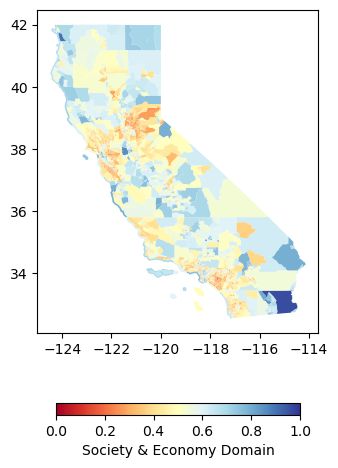

In [47]:
# Merge the DataFrames
df2 = min_max_standardized_society_economy_domain.merge(ca_boundaries, on='GEOID')

# Convert to GeoDataFrame with the correct CRS
df2 = gpd.GeoDataFrame(df2, geometry='geometry', crs=4269)

# Check for invalid geometries
invalid_geometries = df2[~df2['geometry'].is_valid]
print("Number of invalid geometries:", len(invalid_geometries))

# Check if there are any geometries left
if len(df2) == 0:
    print("No valid geometries remaining. Cannot plot.")
else:
    # Set up the figure
    fig, ax = plt.subplots(1, 1, figsize=(4.5, 6))

    # Plot the data
    df2.plot(column='summed_indicators_society_economy_domain_min_max_standardized', 
             ax=ax, 
             vmin=0, vmax=1, 
             legend=True, 
             cmap='RdYlBu',
             legend_kwds={'label': 'Society & Economy Domain', 'orientation': 'horizontal', 'shrink': 0.7})

    # Display the plot
    plt.show()


In [39]:
# Merge the DataFrames
df2 = min_max_standardized_society_economy_domain.merge(ca_boundaries, on='GEOID')

# Update the geometry column
df2['geometry'] = df2['geometry_y']
df2 = df2.drop(columns=['geometry_x', 'geometry_y'])

# Convert to GeoDataFrame with the correct CRS
df2 = gpd.GeoDataFrame(df2, geometry='geometry', crs=4269)

# Check for invalid geometries
invalid_geometries = df2[~df2['geometry'].is_valid]
print("Number of invalid geometries:", len(invalid_geometries))

# Optionally, remove or fix invalid geometries
df2 = df2[df2['geometry'].is_valid]

# Check if there are any geometries left
if len(df2) == 0:
    print("No valid geometries remaining. Cannot plot.")
else:
    # Set up the figure
    fig, ax = plt.subplots(1, 1, figsize=(4.5, 6))

    # Plot the data
    df2.plot(column='summed_indicators_society_economy_domain_min_max_standardized', 
             ax=ax, 
             vmin=-3, vmax=3, 
             legend=True, 
             cmap='RdYlBu',
             legend_kwds={'label': 'Society & Economy Domain', 'orientation': 'horizontal', 'shrink': 0.7})

    # Display the plot
    plt.show()


KeyError: 'geometry_y'